# arccos cuda vs. gt4py

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cmaps

In [3]:
# list gt4py measurement files
[i for i in os.listdir() if "gt4py" in i and "csv" in i and "DEBUG" not in i]

['stencil_gt4py_gpu_306785.csv',
 'stencil_gt4py_gpu_notransfer_308524.csv',
 'timeit_gt4py_cpu_272044.csv',
 'timeit_gt4py_cpu_272261.csv',
 'timeit_gt4py_gpu_272012.csv',
 'timeit_gt4py_gpu_273716.csv',
 'timeit_gt4py_gpu_notransfer_307809.csv']

In [4]:
# list cuda measurement files
[i for i in os.listdir() if "perf" in i and "csv" in i]

['perf_test_cuda_256955.csv',
 'perf_test_cuda_257136.csv',
 'perf_test_cuda_258389.csv',
 'perf_test_cuda_258768.csv',
 'perf_test_cuda_269302.csv']

In [7]:
# read data from files
df = pd.read_csv("perf_test_cuda_257136.csv") # 1 Call, Streams 1,2,4,..512; Size 8,32, ..
df2 = pd.read_csv("perf_test_cuda_269302.csv")  # Calls and Streams 1, 2, 4, .. , 512; Size 8, 32, .. 
df2_1stream = df2[df2["NUM_STREAMS"] == 1].drop(["NUM_STREAMS"], axis=1)
df_gt4py_cpu = pd.read_csv("timeit_gt4py_cpu_272261.csv")
df_gt4py_gpu = pd.read_csv("timeit_gt4py_gpu_273716.csv")
df_gt4py_gpu_notran = pd.read_csv("timeit_gt4py_gpu_notransfer_307809.csv")
df_gt4py_gpu.head()

,Calls,Size,Time
0,1,8,0.004292
1,1,32,0.004245
2,1,128,0.004250
3,1,512,0.004231
4,1,2048,0.004247


Text(0, 0.5, 'runtime [s]')

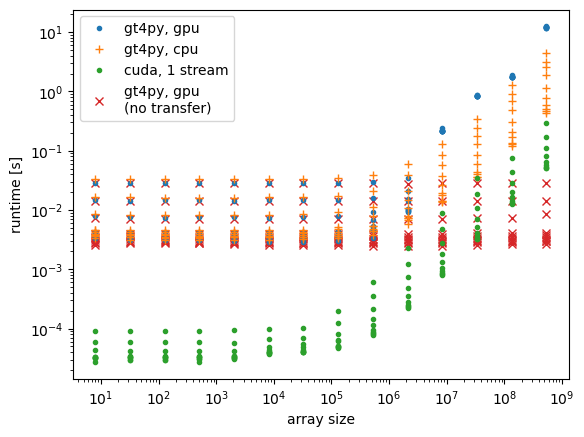

In [13]:
# comparison of different versions --> not very interesting, don't include in report
plt.loglog(df_gt4py_gpu['Size'], df_gt4py_gpu['Time'], ".", label="gt4py, gpu")
plt.loglog(df_gt4py_cpu['Size'], df_gt4py_cpu['Time'], "+", label="gt4py, cpu")
plt.loglog(df2_1stream['Size'], df2_1stream['Time'], ".", label="cuda, 1 stream")
plt.loglog(df_gt4py_gpu_notran['Size'], df_gt4py_gpu_notran['Time'], "x", label="gt4py, gpu\n(no transfer)", zorder=0)
plt.legend(loc='best')
plt.xlabel('array size')
plt.ylabel('runtime [s]')

In [14]:
np.all(df2["Size"].unique() == df_gt4py_gpu["Size"].unique())

True

In [42]:
df2

,Calls,Size,NUM_STREAMS,Time
0,1,8,1,0.000027
1,1,8,2,0.000035
2,1,8,4,0.000043
3,1,32,1,0.000029
4,1,32,2,0.000035
...,...,...,...,...
1212,512,33554432,4,0.032076
1213,512,33554432,8,0.031618
1214,512,33554432,16,0.031522
1215,512,33554432,32,0.031399


## Redo plot, add GT4Py times
(original plot see [cuda_plots.ipynb](cuda_plots.ipynb#time-vs-array-size))

In [5]:
df2["Calls"].unique()

array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512])

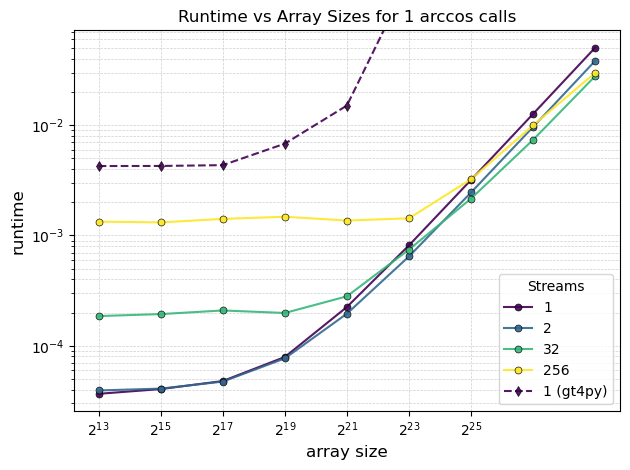

In [18]:
# single call is probably too little compute demand for GT4Py to be fast --> try ncalls=512
ncalls = 1
df2_n = df2[df2["Calls"] == ncalls].drop(["Calls"], axis=1)
df_gtn = df_gt4py_gpu[df_gt4py_gpu["Calls"] == ncalls].drop(["Calls"], axis=1)

streams = [1, 2, 32, 256]
colors = plt.cm.viridis(np.linspace(0, 1, len(streams)))

for idx, i in enumerate(streams):
    sub_df = df2_n[(df2_n['NUM_STREAMS'] == i) & (df2_n['Size'] >= 2**13)]
    plt.plot(sub_df['Size'], sub_df['Time'],
                 marker='o',                # Dots
                 markersize=5,              # Similar to s=10 in scatter
                 alpha=0.9,                 # Transparency
                 markeredgecolor='black',  # Edge color
                 markeredgewidth=0.5,      # Edge thickness
                 label=f'{i:,}',
                 color = colors[idx])
    
plt.xscale('log', base = 2)
tick_exponents = range(13, 26, 2)
tick_values = [2**e for e in tick_exponents]
tick_labels = [f'$2^{{{e}}}$' for e in tick_exponents]
plt.xticks(tick_values, tick_labels)
plt.yscale('log')
plt.xlabel('array size', fontsize = 12)
plt.ylabel('runtime', fontsize = 12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)

xlim = plt.xlim()
ylim = plt.ylim()
sub_df = df_gtn[(df_gtn["Size"] <= 2**25) & (df_gtn["Size"] >= 2**13)]
plt.plot(sub_df['Size'], sub_df['Time'], 'd--',                # Dots
                 markersize=5,              # Similar to s=10 in scatter
                 alpha=0.9,                 # Transparency
                 markeredgecolor='black',  # Edge color
                 markeredgewidth=0.5,      # Edge thickness
                 label=f'{1} (gt4py)',
                 color = colors[0])
plt.xlim(xlim)
plt.ylim(ylim)

plt.legend(title="Streams", loc='lower right', fontsize='medium', title_fontsize='medium')
plt.title(f"Runtime vs Array Sizes for {ncalls} arccos calls")
plt.tight_layout()

# plt.savefig('arccos_runstime_size_streams_incl_gt4py.pdf', bbox_inches='tight')
plt.show()


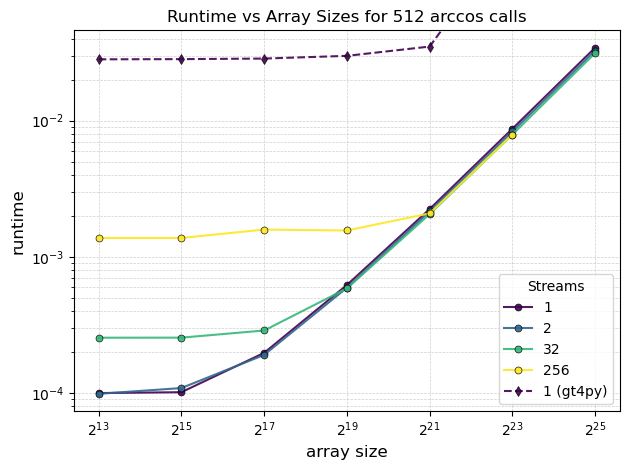

In [ ]:
# shows that even for ncalls=512 GT4Py is slow
# USE IN REPORT
ncalls = 512
df2_n = df2[df2["Calls"] == ncalls].drop(["Calls"], axis=1)
df_gtn = df_gt4py_gpu[df_gt4py_gpu["Calls"] == ncalls].drop(["Calls"], axis=1)

streams = [1, 2, 32, 256]
colors = plt.cm.viridis(np.linspace(0, 1, len(streams)))

for idx, i in enumerate(streams):
    sub_df = df2_n[(df2_n['NUM_STREAMS'] == i) & (df2_n['Size'] >= 2**13)]
    plt.plot(sub_df['Size'], sub_df['Time'],
                 marker='o',                # Dots
                 markersize=5,              # Similar to s=10 in scatter
                 alpha=0.9,                 # Transparency
                 markeredgecolor='black',  # Edge color
                 markeredgewidth=0.5,      # Edge thickness
                 label=f'{i:,}',
                 color = colors[idx])
    
plt.xscale('log', base = 2)
tick_exponents = range(13, 26, 2)
tick_values = [2**e for e in tick_exponents]
tick_labels = [f'$2^{{{e}}}$' for e in tick_exponents]
plt.xticks(tick_values, tick_labels)
plt.yscale('log')
plt.xlabel('array size', fontsize = 12)
plt.ylabel('runtime', fontsize = 12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)

xlim = plt.xlim()
ylim = plt.ylim()
sub_df = df_gtn[(df_gtn["Size"] <= 2**25) & (df_gtn["Size"] >= 2**13)]
plt.plot(sub_df['Size'], sub_df['Time'], 'd--',                # Dots
                 markersize=5,              # Similar to s=10 in scatter
                 alpha=0.9,                 # Transparency
                 markeredgecolor='black',  # Edge color
                 markeredgewidth=0.5,      # Edge thickness
                 label=f'{1} (gt4py)',
                 color = colors[0])
plt.xlim(xlim)
plt.ylim(ylim)

plt.legend(title="Streams", loc='lower right', fontsize='medium', title_fontsize='medium')
plt.title(f"Runtime vs Array Sizes for {ncalls} arccos calls")
plt.tight_layout()

plt.savefig('arccos512_runstime_size_streams_incl_gt4py.pdf', bbox_inches='tight')
plt.show()


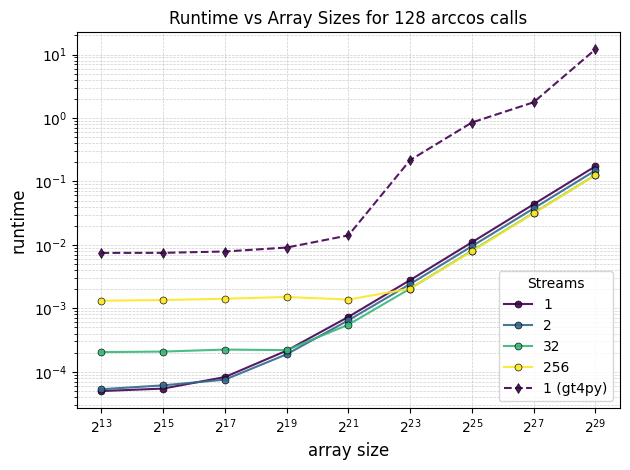

In [ ]:
# not very different from ncalls=512 --> don't use this one
ncalls = 128
df2_n = df2[df2["Calls"] == ncalls].drop(["Calls"], axis=1)
df_gtn = df_gt4py_gpu[df_gt4py_gpu["Calls"] == ncalls].drop(["Calls"], axis=1)

streams = [1, 2, 32, 256]
colors = plt.cm.viridis(np.linspace(0, 1, len(streams)))

for idx, i in enumerate(streams):
    sub_df = df2_n[(df2_n['NUM_STREAMS'] == i) & (df2_n['Size'] >= 2**13)]
    plt.plot(sub_df['Size'], sub_df['Time'],
                 marker='o',                # Dots
                 markersize=5,              # Similar to s=10 in scatter
                 alpha=0.9,                 # Transparency
                 markeredgecolor='black',  # Edge color
                 markeredgewidth=0.5,      # Edge thickness
                 label=f'{i:,}',
                 color = colors[idx])

sub_df = df_gtn[(df_gtn["Size"] <= 2**29) & (df_gtn["Size"] >= 2**13)]
plt.plot(sub_df['Size'], sub_df['Time'], 'd--',                # Dots
                 markersize=5,              # Similar to s=10 in scatter
                 alpha=0.9,                 # Transparency
                 markeredgecolor='black',  # Edge color
                 markeredgewidth=0.5,      # Edge thickness
                 label=f'{1} (gt4py)',
                 color = colors[0])
    
plt.xscale('log', base = 2)
tick_exponents = range(13, 30, 2)
tick_values = [2**e for e in tick_exponents]
tick_labels = [f'$2^{{{e}}}$' for e in tick_exponents]
plt.xticks(tick_values, tick_labels)
plt.yscale('log')
plt.xlabel('array size', fontsize = 12)
plt.ylabel('runtime', fontsize = 12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend(title="Streams", loc='lower right', fontsize='medium', title_fontsize='medium')

plt.title(f"Runtime vs Array Sizes for {ncalls} arccos calls")
plt.tight_layout()

# plt.savefig('arccos_runstime_size_streams.pdf', bbox_inches='tight')
plt.show()


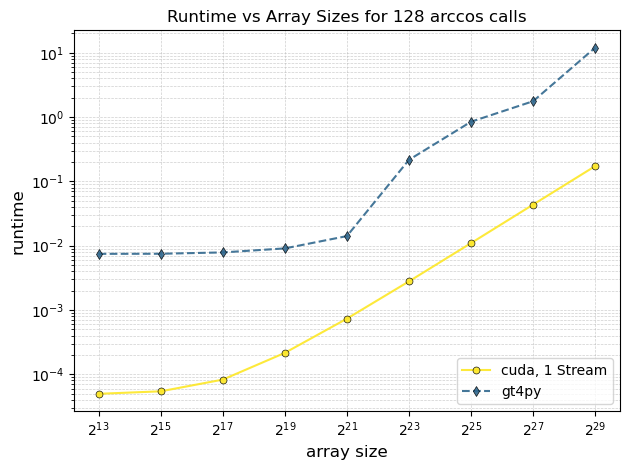

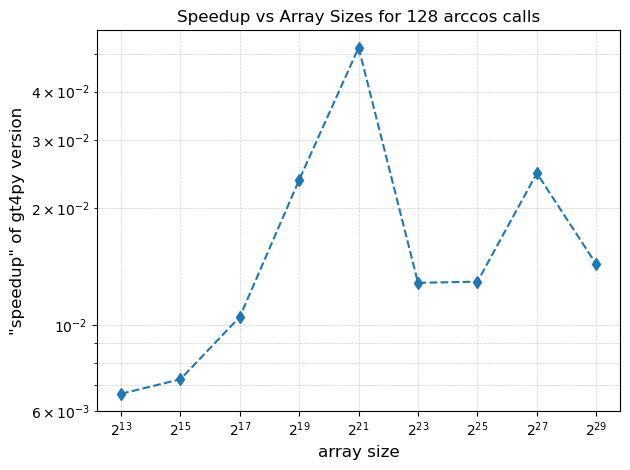

In [20]:
# GT4Py is ~50x slower
ncalls = 128
df2_n = df2[df2["Calls"] == ncalls].drop(["Calls"], axis=1)
df_gtn = df_gt4py_gpu[df_gt4py_gpu["Calls"] == ncalls].drop(["Calls"], axis=1)

streams = [1, 2, 32, 256]
colors = plt.cm.viridis(np.linspace(0, 1, len(streams)))

df2_1 = df2_n[(df2_n['NUM_STREAMS'] == 1) & (df2_n['Size'] >= 2**13)]
plt.plot(df2_1['Size'], df2_1['Time'],
             marker='o',                # Dots
             markersize=5,              # Similar to s=10 in scatter
             alpha=0.9,                 # Transparency
             markeredgecolor='black',  # Edge color
             markeredgewidth=0.5,      # Edge thickness
             label="cuda, 1 Stream",
             color = colors[3])

df_gt1 = df_gtn[(df_gtn["Size"] <= 2**29) & (df_gtn["Size"] >= 2**13)]
plt.plot(df_gt1['Size'], df_gt1['Time'], 'd--',                # Dots
                 markersize=5,              # Similar to s=10 in scatter
                 alpha=0.9,                 # Transparency
                 markeredgecolor='black',  # Edge color
                 markeredgewidth=0.5,      # Edge thickness
                 label=f'gt4py',
                 color = colors[1])
    
plt.xscale('log', base = 2)
tick_exponents = range(13, 30, 2)
tick_values = [2**e for e in tick_exponents]
tick_labels = [f'$2^{{{e}}}$' for e in tick_exponents]
plt.xticks(tick_values, tick_labels)
plt.yscale('log')
plt.xlabel('array size', fontsize = 12)
plt.ylabel('runtime', fontsize = 12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend(loc='lower right', fontsize='medium', title_fontsize='medium')

plt.title(f"Runtime vs Array Sizes for {ncalls} arccos calls")
plt.tight_layout()

# plt.savefig('arccos_runstime_size_streams.pdf', bbox_inches='tight')
plt.show()

# "slowdown plot"
assert(np.all(np.array(df2_1['Size']) == np.array(df_gt1['Size'])))
plt.plot(df_gt1['Size'], df2_1['Time'].to_numpy() / df_gt1['Time'].to_numpy(), 'd--')
plt.xscale('log', base = 2)
tick_exponents = range(13, 30, 2)
tick_values = [2**e for e in tick_exponents]
tick_labels = [f'$2^{{{e}}}$' for e in tick_exponents]
plt.xticks(tick_values, tick_labels)
plt.yscale('log')
plt.xlabel('array size', fontsize = 12)
plt.ylabel('"speedup" of gt4py version', fontsize = 12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)

plt.title(f"Speedup vs Array Sizes for {ncalls} arccos calls")
plt.tight_layout()

## optimal number of streams
The following code was suggested by chatGPT:

In [16]:
# Step 1: Find the indices of the minimal Time per (Calls, Size)
min_time_idx = df2.groupby(['Calls', 'Size'])['Time'].idxmin()

# Step 2: Use .loc[] to extract the rows with minimal time
df_min_streams = df2.loc[min_time_idx].sort_values(['Calls', 'Size'])

# Optional: Just show the relevant columns
result = df_min_streams[['Calls', 'Size', 'NUM_STREAMS', 'Time']]


In [21]:
result

,Calls,Size,NUM_STREAMS,Time
0,1,8,1,0.000027
3,1,32,1,0.000029
8,1,128,1,0.000030
15,1,512,1,0.000027
24,1,2048,1,0.000030
...,...,...,...,...
1172,512,131072,4,0.000189
1184,512,524288,16,0.000579
1196,512,2097152,64,0.002057
1207,512,8388608,128,0.007896


In [90]:
from matplotlib.colors import LogNorm

calls = result['Calls'].unique()
sizes  = result['Size'].unique()

# fill a 2d matrix with the num_streams values from result and mask out missing values
matrix2d = np.empty((len(calls),len(sizes)))
print(matrix2d.shape)
matrix2d[:] = np.nan
for call,size,nstreams in result.to_numpy()[:,:3]:
    i = np.argmax(call == calls)
    j = np.argmax(size == sizes)
    matrix2d[i,j] = nstreams
matrix2d = np.ma.masked_invalid(matrix2d)  # mask out NaN values

(10, 14)


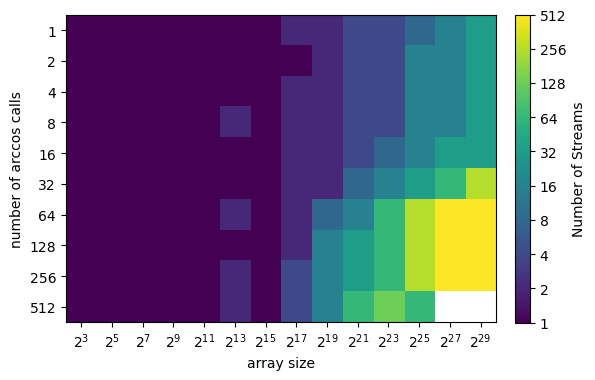

In [89]:
# no clear pattern --> not in report
plt.figure(figsize=(6,4))
norm = LogNorm(vmin=np.nanmin(matrix2d), vmax=np.nanmax(matrix2d))
im = plt.imshow(matrix2d, norm=norm)
plt.xlabel('array size')
plt.ylabel('number of arccos calls')
plt.xticks(np.arange(14), [f'$2^{{{int(e)}}}$' for e in np.log2(sizes)])
plt.yticks(np.arange(10), calls)
cbar = plt.colorbar(im, label='Number of Streams', fraction=0.035, pad=0.04)
cbar.set_ticks(2**np.arange(10))
cbar.set_ticklabels(2**np.arange(10))
cbar.ax.minorticks_off()